# Master model development

## John Brandt

### Last updated: November 1 2019

*  Package loading
*  Hyperparameter definitions
*  Additional layer definitions
*  Model definition
*  Data loading
*  Data preprocessing
*  K means clustering
*  Augment training data
*  Loss definition
*  Equibatch creation
*  Model training
*  Model validation and sanity checks

In [1]:
# Notes
# The model is very sensitive to zoneout prob, do not go above 0.05/
# AdaBound seems to perform worse, stick to Adam with step down loss
# 32 x 24 x 32 model overfits after 100 epochs
# Investigate more hypercolumn parametrizations to increase available data at output 
#    while maintaining low dimensionality of filters
# 5e-4 LR worked, investigating 8e-4 for 60% faster training time
# ONLY CHANGE ONE THING AT A TIME

In [2]:
#TODO Remove imports that aren't needed to save RAM
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add, Bidirectional, ConvLSTM2D

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [3]:
%run ../src/zoneout.py
%run ../src/convgru.py
%run ../src/lovasz.py
%run ../src/utils.py
%run ../src/adabound.py
%run ../src/slope.py
%run ../src/dropblock.py

# Hyperparameter definitions

In [4]:
ZONE_OUT_PROB = 0.20
L2_REG = 0.0
INITIAL_LR = 2e-4
FINAL_LR = 1e-3
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
MAX_DROPBLOCK = 0.85

STEPS = 24

gru_flt = 12
fpa_flt = 32
out_conv_flt = 32


AUGMENTATION_RATIO = 4
IMAGE_SIZE = 14
existing = [int(x[:-4]) for x in os.listdir('../data/final/') if ".DS" not in x]
N_SAMPLES = len(existing)

LABEL_SIZE = 14

    
TRAIN_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) * TRAIN_RATIO)
TEST_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) - TRAIN_SAMPLES)
print(TRAIN_SAMPLES // AUGMENTATION_RATIO, N_SAMPLES - (TRAIN_SAMPLES // AUGMENTATION_RATIO))

539 135


# Additional layer definitions

In [5]:
def conv_bn_elu(inp, is_training, kernel_size, scope, filter_count = 16, pad = True, padding = 'valid', dilated = False):
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = selu,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = selu,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = selu, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv

def td_conv_bn_elu(inp, filter_count = 32, size = 3):
    #padded = TimeDistributed(ReflectionPadding2D((1, 1,)))(inp)
    if size == 3:
        padded = tf.pad(inp, [[0,0], [0,0], [1,1], [1,1], [0,0] ], 'REFLECT')
        conv = TimeDistributed(Conv2D(filters = filter_count, kernel_size = (3, 3),
                          padding = 'valid', activation = selu, kernel_initializer = lecun_normal()))(padded)
    else:
        conv = TimeDistributed(Conv2D(filters = filter_count, kernel_size = (1, 1),
                          padding = 'valid', activation = selu, kernel_initializer = lecun_normal()))(inp)
    #bn = TimeDistributed(Batch_Normalization(elu, training=is_training, scope = scope + "bn")
    return conv

def upconv2d(X, filters, is_training, amt, scope):
    X = tf.image.resize_images(X, [X.shape[1]+amt, X.shape[2]+amt],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    X = conv_bn_elu(X, is_training, 1, scope, filters, False, 'valid')
    return X
    
    
def fpa(inp, is_training, filter_count, scope = 'fpa'):
    one = conv_bn_elu(inp, is_training, 1, scope + 'forward1', filter_count, False, 'valid')
    three = conv_bn_elu(inp, is_training, 3, scope + 'down2', filter_count, True, 'valid') 
    five = conv_bn_elu(inp, is_training, 3, scope + 'down2', filter_count, True, 'valid', dilated = True) 
    concat_1 = tf.multiply(one, tf.add(three, five))
    return concat_1


def inp_fpa(inp, is_training, filter_count, scope):
    one = td_conv_bn_elu(inp, filter_count, 1)
    three = td_conv_bn_elu(inp, filter_count, 3)
    concat_1 = tf.multiply(one, three)
    return concat_1

def dist_fpa(inp, is_training, filter_count, length):
    
    stacked = tf.reshape(inp, (-1, 14, 14, 17*24))
    c1 = Conv2D(filters = filter_count, kernel_size = (1, 1),
                          padding = 'valid', activation = selu, kernel_initializer = lecun_normal())(stacked)
    #one, one_f = gru_block(inp = inp, length = length, size = [16, 16], kernel_size = 1,
    #                flt = filter_count, scope = 'gru1', pad_input = False, train = is_training, reg = gru_reg)
    
    three, three_f = gru_block(inp = inp, length = length, size = [14, 14], kernel_size = 3,
                    flt = filter_count, scope = 'gru3', pad_input = True, train = is_training, reg = gru_reg)
    
    #three = temporal_attention(three, 10)
    #four_top = TimeDistributed(tf.keras.layers.UpSampling2D((14, 14)))(one_top)
    concat_1 = tf.concat([c1, three_f], -1)
    #concat_f = tf.concat([one_f, three_f], axis = -1)
    #concat_2 = temporal_attention(concat_1, 20)
    #concat_2 = tf.concat([concat_2, concat_f], axis = -1)

    return concat_1
    
    
def create_deconv_init(filter_size, num_channels):
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init


def get_deconv2d(inp, filter_count, num_channels, scope, is_training):
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', activation = 'relu',
                                        kernel_initializer = bilinear_init)(inp)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn")
    return x


def Batch_Normalization(x, training, scope):
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               name = scope)

def cse_block(prevlayer, prefix):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="he_normal",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    

def temporal_attention(inp, units):
    # This rescales each output
    # Timesteps that are more important get weighted higher
    # Timesteps that are least important get weighted lower --> B, N, H, W, C
    conved = TimeDistributed(Conv2D(units, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'tanh', strides = (1, 1)))(inp)
    
    
    #conved = tf.reshape(conved, (-1, units, 16, 16, STEPS))
    print("Attention weight shape: {}".format(conved.shape))
    conved = TimeDistributed(Conv2D(1, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'sigmoid', use_bias = False, strides = (1, 1)))(conved)
    print("Conved sigmoid shape: {}".format(conved.shape))
    #conved = tf.reshape(conved, (-1, 24, 1, 1, 1))
    
    alphas = tf.reduce_sum(conved, axis = 1, keep_dims = True)
    print("Attention alphas: {}".format(alphas.shape))
    # We need to calculate the total sum for each pixel for each channel, so that we can combine them
    alphas = conved / alphas
    print("Attention weight shapes {}".format(alphas.shape))
    
    # This actually multiplies the Conv by the input
    multiplied = tf.reduce_sum(alphas * inp, axis = 1)
    return multiplied
    
def gru_block(inp, length, size, flt, scope, train, reg, kernel_size = 1, pad_input = True, normalize = True):
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [kernel_size, kernel_size], pad_input = pad_input, normalize = normalize)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [kernel_size, kernel_size], pad_input = pad_input, normalize = normalize)
        cell_fw = ZoneoutWrapper(
            cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        output, final_state = convGRU(inp, cell_fw, cell_bw, length)
        output = tf.concat(output, axis = -1)
    return output, tf.concat(final_state, axis = -1)

# Model definition

In [6]:
reg = keras.regularizers.l2(L2_REG)
gru_reg = tf.contrib.layers.l2_regularizer(scale = 1e-10)
inp = tf.placeholder(tf.float32, shape=(None, STEPS, IMAGE_SIZE, IMAGE_SIZE, 17))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ())
length2 = tf.reshape(length, (-1,))
is_training = tf.placeholder_with_default(False, (), 'is_training')
    
    
gru = dist_fpa(inp, is_training, gru_flt, length2)
print("GRU shape :{}".format(gru.shape))

csse1 = csse_block(gru, "csse_conv1")
drop1 = DropBlock2D(keep_prob = keep_rate, block_size = 3)
gru_drop1 = drop1(csse1, is_training)


fpa = fpa(gru_drop1, is_training, fpa_flt)
fpa = csse_block(fpa, "fpa_conv1")

#out_concat = tf.concat([gru_drop1, fpa], axis = -1)
out_conv2 = conv_bn_elu(fpa, is_training, 3, "out_conv2", out_conv_flt, pad = True)

out_concat = tf.concat([out_conv2, fpa, gru_drop1], axis = -1)
print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            kernel_initializer = 'glorot_uniform',
            bias_initializer = init,
           )(out_concat) # For focal loss

GRU input shape (?, 24, 14, 14, 17), zoneout: 0.2
GRU shape :(?, 14, 14, 36)
Initializing last sigmoid bias with -2.94 constant


In [7]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 58853 parameters


In [8]:
df = pd.read_csv("../data/subplot.csv")
df1 = pd.read_csv("../data/subplot2.csv")
df2 = pd.read_csv("../data/subplot3.csv")
df3 = pd.read_csv("../data/subplot4.csv")

df = df.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df1 = df1.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df2 = df2.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df3 = df3.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)

lens = [len(x) for x in [df, df1, df2, df3]]

df = pd.concat([df, df1, df2, df3], ignore_index = True)
df = df.dropna(axis = 0)

existing = [int(x[:-4]) for x in os.listdir('../data/correct_dem/') if ".DS" not in x]
N_SAMPLES = len(existing)

In [9]:
df = df[df['PLOT_ID'].isin(existing)]
N_SAMPLES = int(df.shape[0]/196)
N_YEARS = 1

plot_ids = sorted(df['PLOT_ID'].unique())


def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

data = [reconstruct_images(x) for x in plot_ids]


# Initiate empty lists to store the X and Y data in
data_x, data_y, lengths = [], [], []

# Iterate over each plot
for i in tnrange(len(plot_ids)):
    # Load the sentinel imagery
    for year in ["correct_dem"]:  
        x = np.load("../data/" + year + "/" + str(plot_ids[i]) + ".npy")
        x = ndvi(x, image_size = 16)
        x = evi(x, image_size = 16)
        x = savi(x, image_size = 16)
        x = bi(x)
        x = msavi2(x)
        x = si(x)
        x = remove_blank_steps(x)
        y = reconstruct_images(plot_ids[i])
        x = x[:, 1:15, 1:15, :]
        x[:, :, :, 10] /= 90
        lengthi = x.shape[0]
        if x.shape[0] < 24:
            padding = np.zeros((24 - x.shape[0], IMAGE_SIZE, IMAGE_SIZE, 17))
            x = np.concatenate((x, padding), axis = 0)
        if STEPS == 12:
            x = np.mean(np.reshape(x, (12, 2, 14, 14, 17)), axis = 1)
            lengthi = x.shape[0]
        if STEPS == 6:
            x = np.mean(np.reshape(x, (6, 4, 14, 14, 17)), axis = 1)
            lengthi = x.shape[0]
        lengths.append(lengthi)
        data_x.append(x)
        data_y.append(y)
print("Finished data loading")

data_x = np.stack(data_x)
data_y = np.stack(data_y)
lengths = np.stack(lengths)
print(data_x.shape)


Finished data loading
(682, 24, 14, 14, 17)


In [10]:
np.max(data_x[:, :, :, :, 10])

0.8164800855848524

# Data preprocessing

In [11]:
below_1 = [i for i, val in enumerate(data_x) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(data_x) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(data_x) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(data_x) if np.max(val) > 1.5]
outliers = below_1 + above_1
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
data_x = data_x[[x for x in range(0, len(data_x)) if x not in outliers]]
data_y = data_y[[x for x in range(0, len(data_y)) if x not in outliers]]
lengths = lengths[[x for x in range(0, len(lengths)) if x not in outliers]]

min_all = []
max_all = []
for x in range(0, data_x.shape[-1]):
    mins, maxs = (np.min(data_x[:, :, :, :, x]), np.max(data_x[:, :, :, :, x]))
    min_all.append(mins)
    max_all.append(maxs)
    
    data_x[:, :, :, :, x] = (data_x[:, :, :, :, x] - mins) / (maxs - mins)
    
print("The data has been scaled to [{}, {}]".format(np.min(data_x), np.max(data_x)))

The outliers are: [7, 45, 141, 195, 292, 324, 327, 336, 363, 382, 385, 440, 497, 549, 601, 610, 652, 661, 7, 195, 225, 318, 487, 497, 634, 661], totalling 26


[-6.321969935282787, -4.535834700871396, -21.676083445072493, -2.2993393536632385, -1.8042645341712162, -1.993483055138996, -4.2340957103651276, -154.96879970980808, -7.498300327395563, -27.994200363871652, -2.238301983142812, -11.793600000161678, -738.3066513950349, -7.680050306753378, -5.0129133495892875, -4.151812073196412, -4.458718742819538, -554.9390321317858] [5.0, 5.0, 5.0, 5.0, 5.0, 4291.504339112331, 5.0, 144.11851966358546]
The data has been scaled to [0.0, 1.0]


In [12]:
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x for x in outliers]))]
N_SAMPLES = len(data_x)

region_lengths = []
for x in [df1, df2, df3]:
    subs = [i for i in set(x['PLOT_ID']) if i in plot_ids2]
    region_lengths.append(len(subs))
    
region_lengths = [N_SAMPLES - sum(region_lengths)] + region_lengths

print("The region sample distribution is {}".format(region_lengths))
print(sum(region_lengths))
train_ordering = []
test_ordering = []
ordering = []
total_samples = 0
for r in TRAIN_RATIO, TEST_RATIO:
    for i, val in enumerate(region_lengths):
        start = int(np.sum(region_lengths[:i]))
        end = start + val
        if r == 0.8:
            start = start
            end = end-((end-start)*(1-r))
            start = int(start)
            end = int(end)
            total_samples += (end - start)
            train_ordering += [x for x in range(start, end)]
        if r == 0.2:
            start = start + ((end-start)*(1-r))
            end = end
            start = int(start)
            end = int(end)
            total_samples += (end-start)
            test_ordering += [x for x in range(start, end)]

ordering = train_ordering + test_ordering

data_x = data_x[ordering]
data_y = data_y[ordering]
lengths = lengths[ordering]

The region sample distribution is [196, 131, 149, 184]
660


# K Means clustering

In [13]:
from sklearn.cluster import KMeans

NONZERO_CLUSTERS = 10
ZERO_CLUSTERS = 6

kmeans = KMeans(n_clusters=NONZERO_CLUSTERS, random_state = 50)
kmeans_zero = KMeans(n_clusters = ZERO_CLUSTERS, random_state = 50)
unaugmented = [x for x in range(0, len(data_y))]
zeros = [x for x in unaugmented if np.sum(data_y[x]) == 0]
nonzero = [x for x in unaugmented if x not in zeros]
kmeans.fit(data_y[nonzero, :, :].reshape((len(nonzero), 14*14)))
kmeans_zero.fit(np.mean(data_x[zeros, :, :], axis = 1).reshape((len(zeros), 14*14*17)))             

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [14]:
def multiplot(matrices):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()

[143, 236, 348, 486]


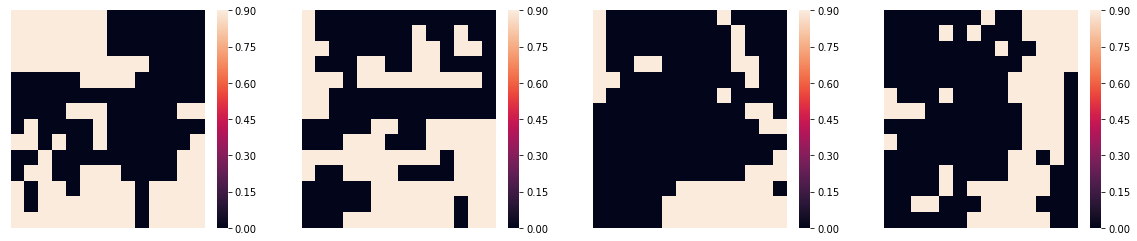

In [15]:
import random 
samples_x = [val for x, val in enumerate(nonzero) if kmeans.labels_[x] == 1]
print(samples_x)
randoms = random.sample(samples_x, 4)
randoms = [data_y[x] for x in randoms]
randoms = [x.reshape((14, 14)) for x in randoms]
multiplot(randoms)

In [16]:
percs = np.sum(data_y.reshape((-1, 14*14)), axis = 1)
idx = [x for x in range(0, len(data_y))]
print([i for x, i in enumerate(sorted(percs)) if x % (len(data_y)//15) == 0 ])

ids = {
    0: [x for x, z in zip(idx, percs) if 0 < z <= 5],
    1: [x for x, z in zip(idx, percs) if 5 < z <= 9],
    2: [x for x, z in zip(idx, percs) if 9 < z <= 14],
    3: [x for x, z in zip(idx, percs) if 14 < z <= 19],
    4: [x for x, z in zip(idx, percs) if 19 < z <= 27],
    5: [x for x, z in zip(idx, percs) if 27 < z <= 33],
    6: [x for x, z in zip(idx, percs) if 33 < z <= 41],
    7: [x for x, z in zip(idx, percs) if 41 < z <= 56],
    8: [x for x, z in zip(idx, percs) if 56  < z <= 93],
    9: [x for x, z in zip(idx, percs) if 93 < z <= 120],
    10: [x for x, z in zip(idx, percs) if 120 < z]
}

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 5.0, 9.0, 14.0, 19.0, 27.0, 32.0, 41.0, 56.0, 93.0]


In [17]:
def balance_data(data_y, ids, labels, labels2, unaugmented = unaugmented):
    # Loop over the nonzero clusters
    #for i in range(0, NONZERO_CLUSTERS):
    #    tmp = [val for x, val in enumerate(nonzero) if labels[x] == i]
    #    ids[i] = tmp
    # Loop over the zero clusters
    for i in range(0, ZERO_CLUSTERS):
        tmp = [val for x, val in enumerate(zeros) if labels2[x] == i]
        ids[i + 11] = tmp
    #ids[10] = zeros
    return ids



In [18]:
ids = balance_data(data_y, ids, kmeans.labels_, kmeans_zero.labels_ )
items = [v for k, v in ids.items()]
items = [item for sublist in items for item in sublist]
print("The {} samples have been balanced between the sampling sites".format(len(items)))

The 660 samples have been balanced between the sampling sites


In [19]:
train_ids = []
test_ids = []
for i in ids:
    ln = len(ids[i])
    train_len = int(np.floor([ln * TRAIN_RATIO]))
    test_len = ln - train_len
    print(train_len, test_len, ln)
    trains = ids[i][:train_len]
    tests = ids[i][train_len:]
    train_ids += trains
    test_ids += tests
    
train_labels = []
for i in train_ids:
    train_labels.append([k for k, v in ids.items() if i in v][0])

45 12 57
36 10 46
33 9 42
36 10 46
36 9 45
33 9 42
36 9 45
32 8 40
35 9 44
12 3 15
21 6 27
38 10 48
38 10 48
23 6 29
31 8 39
8 2 10
29 8 37


In [20]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in data_y[train_ids]])))
print("Test mean Y {}".format(np.mean([np.sum(x) for x in data_y[test_ids]])))
print("Train STD Y {}".format(np.std([np.sum(x) for x in data_y[train_ids]])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in data_y[test_ids]])))
print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))


Train and test characteristics:
Train mean Y 25.408045977011493
Test mean Y 26.043478260869566
Train STD Y 37.159903157774835
Test STD Y 40.88918739560272
Train number with zero trees 33.4
Test number with zero trees 35.2
Train mean NDVI
Test mean NDVI
There are 522 train and 138 test samples
There is 0 overlap between train and test


# Augment training data

In [21]:
data_x_augmented = []
data_y_augmented = []
lengths_augmented = []
labels_augmented = []
for i, val in enumerate(train_ids):
    data_x_augmented.append(data_x[val])
    data_y_augmented.append(data_y[val])
    lengths_augmented.append(data_x[val].shape[0])
    labels_augmented.append(train_labels[i])
    
    x1 = np.flip(data_x[val], 1)
    y1 = np.flip(data_y[val], 0)
    lengths_augmented.append(x1.shape[0])
    labels_augmented.append(train_labels[i])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], [2, 1])
    y1 = np.flip(data_y[val], [1, 0])
    lengths_augmented.append(x1.shape[0])
    labels_augmented.append(train_labels[i])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], 2)
    y1 = np.flip(data_y[val], 1)
    lengths_augmented.append(x1.shape[0])
    labels_augmented.append(train_labels[i])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)

train_x = np.stack(data_x_augmented)
train_y = np.stack(data_y_augmented)
train_y = np.reshape(train_y, (train_y.shape[0], 14, 14, 1))
train_l = np.stack(lengths_augmented)
train_l = np.reshape(train_l, (train_y.shape[0], 1))

In [22]:
test_x = data_x[test_ids]
test_y = data_y[test_ids]
test_lengths = lengths[test_ids]

RANDOM TRAIN SAMPLES - SHOULD BE AUGMENTED


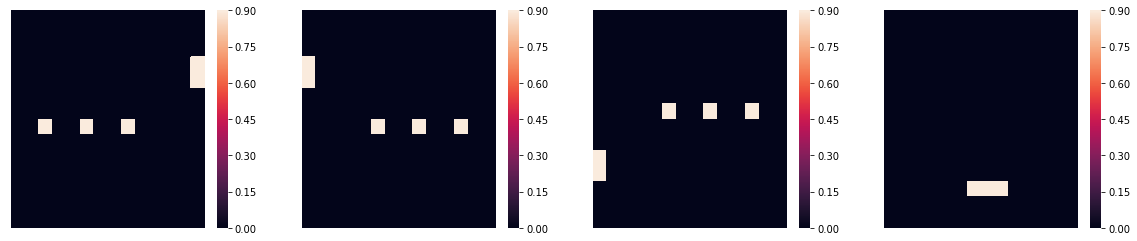

In [23]:
print("RANDOM TRAIN SAMPLES - SHOULD BE AUGMENTED")
multiplot([x.reshape(14, 14) for x in train_y[25:29]])

RANDOM TEST SAMPLES - SHOULD BE NOT AUGMENTED


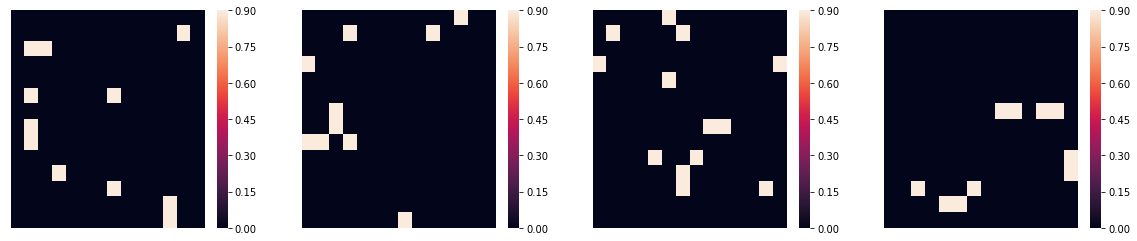

In [24]:
print("RANDOM TEST SAMPLES - SHOULD BE NOT AUGMENTED")
multiplot([x.reshape(14, 14) for x in test_y[25:29]])

# Loss definition

In [25]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
import math

def smooth_jaccard(y_true, y_pred, smooth=1):
    y_true = tf.reshape(y_true, (-1, 14*14))
    y_pred = tf.reshape(y_pred, (-1, 14*14))
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def focal_loss_fixed(y_true, y_pred, gamma = 2., alpha = 0.25):
    y_true = tf.reshape(y_true, (-1, 14*14, 1))
    y_pred = tf.reshape(y_pred, (-1, 14*14, 1))
    y_pred = K.clip(y_pred, 1e-8, 1-1e-8)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
    pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
    pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
    loss = -K.mean(alpha * 1 * K.log(K.epsilon()+pt_1)) - K.mean((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return 2 * tf.reduce_mean(loss)

def bce_jaccard(y_true, y_pred):
    jac = smooth_jaccard(y_true, y_pred)
    bce = binary_crossentropy(y_true, y_pred)
    return bce + 0.15*tf.reshape(jac, (-1, 1, 1, 1))

def weighted_bce_loss(y_true, y_pred, weight = 1.3, smooth = 0.01, mask = None):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    #y_true = K.clip(y_true, smooth, 1. - smooth)
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    #loss = loss * mask
    return tf.reduce_mean(loss)

from scipy.ndimage import distance_transform_edt as distance

def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res

def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

def bce_lv(y_true, y_pred, alpha, smooth = 0.01, mask = None, ):
    #y_true_s = K.clip(y_true, smooth, 1. - smooth)
    bce = (0.85 - alpha) * weighted_bce_loss(y_true, y_pred, mask = mask)
    surf = surface_loss(y_true, y_pred)
    #print(surf.shape)
    lv = (0.15 + alpha) * lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=False)
    global_loss = (1 - alpha) * (bce + lv)
    regional_loss = alpha * surf
    return global_loss + regional_loss


def lovasz(y_true, y_pred):
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return tf.reduce_mean(lv)

def calculate_metrics():
    best_f1 = 0
    best_thresh = 0
    p = 0
    r = 0
    error = 0
    ys = []
    vls = []
    t_alls = []
    for test_sample in test_ids:
        y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[test_sample].reshape(1, STEPS, 14, 14, 17),
                                          length: test_lengths[test_sample].reshape(1, 1),
                                          is_training: False,
                                          labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                          })
        ys.append(y.reshape((14, 14)))
        vls.append(vl)
        t = test_y[test_sample].reshape((14, 14))
        t_alls.append(t)
    for thresh in range(8, 13):
        tps = []
        fps = []
        fns = []
        perc_error = []
        trues = []
        preds = []
        val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            vl = vls[sample]
            pred[np.where(pred > thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            true_s = np.sum(true)
            pred_s = np.sum(pred)
            #true_p = true_s - (true_s - pred_s)
            perc_error.append(abs(pred_s - true_s) / 196)
            tp, fp, fn = thirty_meter(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            val_loss.append(np.mean(vl))
        oa_error = abs(np.sum(preds) - np.sum(trues)) / np.sum(trues)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))
        if f1 > best_f1:
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            best_thresh = thresh*0.05
    print("Val loss: {} Thresh: {} F1: {} Recall: {} Precision: {} Error: {}".format(np.around(np.mean(val_loss), 3), np.around(best_thresh, 2),
                                                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                                                     np.around(error, 3)))
    return best_f1

In [26]:
train_ids = [x for x in range(0, len(train_y))]
print(len(train_ids))

2088


# Equibatch creation

In [36]:

def equibatch(train_ids, lovasz = False):
    first_len = 5
    second_len = 9
    third_len = 14
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    zero_ids = [x for x, z in zip(ix, percs) if z == 0]
    one_ids = [x for x, z in zip(ix, percs) if 0 < z <= first_len]
    two_ids = [x for x, z in zip(ix, percs) if first_len < z <= second_len]
    three_ids = [x for x, z in zip(ix, percs) if second_len < z <= third_len]
    four_ids = [x for x, z in zip(ix, percs) if third_len < z <= 19]
    five_ids = [x for x, z in zip(ix, percs) if 19 < z < 27]
    six_ids = [x for x, z in zip(ix, percs) if 27 < z <= 33]
    seven_ids = [x for x, z in zip(ix, percs) if 33 < z <= 41]
    eight_ids = [x for x, z in zip(ix, percs) if 41 < z <= 56]
    nine_ids =  [x for x, z in zip(ix, percs) if 56 < z <= 80]
    ten_ids =  [x for x, z in zip(ix, percs) if 80 < z <= 120]
    eleven_ids = [x for x, z in zip(ix, percs) if 120 < z]
    #ten_ids = [x for x, z in zip(ix, percs) if 125 < z]
    
    

    all_ids = [x for x in [zero_ids, one_ids, two_ids, three_ids, four_ids, five_ids, six_ids,
              seven_ids, eight_ids, nine_ids, ten_ids, eleven_ids]]
    
    new_batches = []
    maxes = [len(zero_ids), len(one_ids), len(two_ids), len(three_ids), len(four_ids),
             len(five_ids), len(six_ids), len(seven_ids), len(eight_ids), len(nine_ids), len(ten_ids), len(eleven_ids)]#, len(ten_ids)]
    cur_ids = [0] * 12
    iter_len = len(train_ids)// 13
    for i in range(0, iter_len):
        random_ids = np.random.randint(0, 12, 3)
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 5:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [zero_ids[cur_ids[0]], zero_ids[cur_ids[0] + 1], one_ids[cur_ids[1]], two_ids[cur_ids[2]],
                    three_ids[cur_ids[3]], four_ids[cur_ids[4]], five_ids[cur_ids[5]],
                    six_ids[cur_ids[6]], seven_ids[cur_ids[7]], eight_ids[cur_ids[8]],
                               nine_ids[cur_ids[9]], ten_ids[cur_ids[10]], eleven_ids[cur_ids[11]],
                    
                    all_ids[random_ids[0]][cur_ids[random_ids[0]]+1],
                    all_ids[random_ids[1]][cur_ids[random_ids[1]]+1],
                    all_ids[random_ids[2]][cur_ids[random_ids[2]]]+1]
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        cur_ids[0] += 1
        for x in random_ids:
            cur_ids[x] += 1
        
    new_batches = [item for sublist in new_batches for item in sublist]
    #overlap = [x for x in new_batches if x in test_ids]
    #print("There is {} overlap. Error if > 0".format(len(overlap)))
    return new_batches

In [28]:
batch = equibatch(train_ids, True)

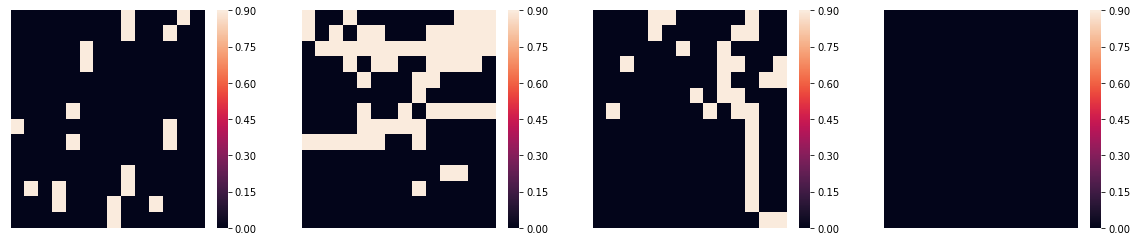

In [29]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[:4]]])

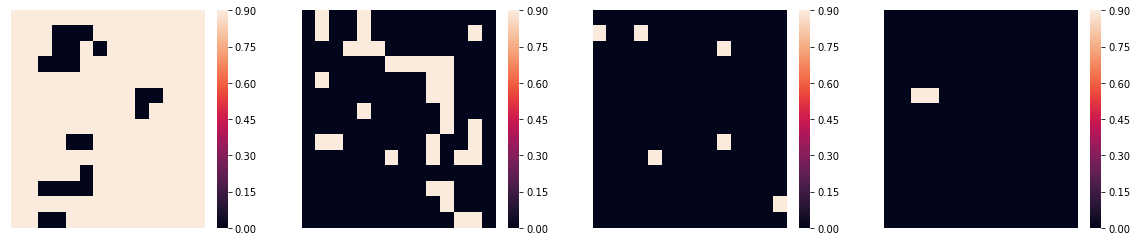

In [30]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

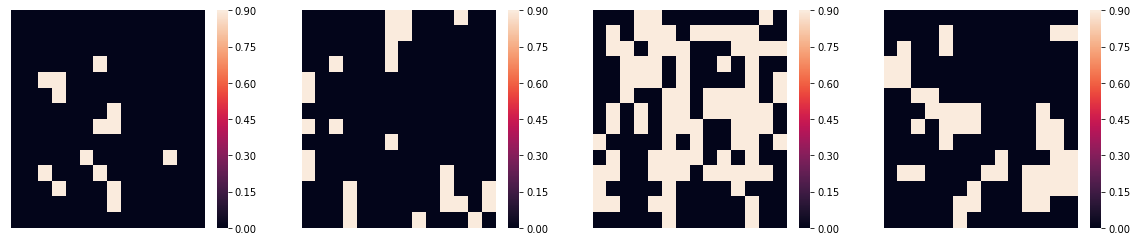

In [31]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

In [32]:
np.mean([np.sum(x) for x in train_y[batch]])

38.347115384615385

In [33]:
#new_saver = tf.train.import_meta_graph('../models/f1_auc/model.meta')
#new_saver.restore(sess, tf.train.latest_checkpoint('../models/f1_auc/'))

In [34]:
def get_batch_loss_weights(idx):
    weights = []
    for i in idx:
        mask = np.copy(np.reshape(train_y[i], (14, 14)))
        zeros = np.argwhere(mask == 0)

        loss_mask = np.ones((14, 14))
        for x, y in zeros:
            if x < 13:
                if mask[x+1, y] == 1:
                    loss_mask[x, y] = 0.8
            if x > 0:
                if mask[x - 1, y] == 1:
                    loss_mask[x, y] = 0.8
            if y > 0:
                if mask[x, y - 1] == 1:
                    loss_mask[x, y] = 0.8
            if y < 13:
                if mask[x, y + 1] == 1:
                    loss_mask[x, y] = 0.8
        weights.append(loss_mask)
    
    return np.reshape(np.stack(weights), (-1, 14, 14, 1))

loss_weights = tf.placeholder(tf.float32, shape=(None, 14, 14, 1))
alpha = tf.placeholder(tf.float32, shape = ())

# Model training

In [37]:
FRESH_START = False
FINE_TUNE = False
from tensorflow.python.keras.optimizers import SGD
learning_rate = tf.placeholder(tf.float32, shape=[])


BATCH_SIZE = 48
print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))
best_val = 0.620
if not FRESH_START:
    print("Resuming training with a best validation score of {}".format(best_val))
if FRESH_START:
    print("Restarting training from scratch on {} train and {} test samples, total {}".format(len(train_ids), len(test_ids), N_SAMPLES))

    optimizer = tf.train.AdamOptimizer(8e-4, epsilon = 1e-8)
    #optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, clip_norm=10.0)
    #optimizer = AdaBoundOptimizer(1e-2, 1e-2, amsbound = True)

    ft_optimizer = tf.train.AdamOptimizer(1e-4, epsilon = 1e-3)
    ft_optimizer = tf.contrib.estimator.clip_gradients_by_norm(ft_optimizer, clip_norm=1.0)
    
    train_loss = bce_lv(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha = alpha, mask = loss_weights)
    test_loss = tf.reduce_mean(binary_crossentropy(tf.reshape(labels, (-1, 14, 14, 1)), fm))
    ft_loss = lovasz(tf.reshape(labels, (-1, 14, 14, 1)), fm)
    #l2_loss = tf.losses.get_regularization_loss()
    #train_loss += l2_loss
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        #wu_op = wu_optimizer.minimize(wu_loss)
        ft_op = ft_optimizer.minimize(ft_loss)
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 2)

# Run training 1oop
for i in range(0, 300):
    randomize = equibatch(train_ids, lovasz = False)
    randomize = [np.min([x, len(train_y) - 1]) for x in randomize]
    #randomize = [x for x in range(0, len(train_ids))]
    #np.random.shuffle(randomize)
        #print("Loss: BCE + 0.30 Lovasz")
    op = train_op
    loss = train_loss
    #op = ft_op
    #loss = ft_loss
    BATCH_SIZE = 16
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    bce_losses = []
    
    al = np.min([i*0.01, 0.7])
    print("Loss: {} 1.3 weighted BCE + {} Batch Lovasz + {} Boundary".format( (0.85-al) * (1 - al), (1 - al) * (0.15 + al), al))
    
    for k in tnrange(int(len(train_ids) // BATCH_SIZE)):
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        batch_y = train_y[batch_ids, :, :].reshape(len(batch_ids), 14, 14)
        opt, tr = sess.run([op, loss],
                              feed_dict={inp: train_x[batch_ids, :, :, :],
                                         length: train_l[batch_ids].reshape((-1, 1)),
                                         labels: batch_y,
                                         is_training: True,
                                         keep_rate: np.max((1 - (i*0.002), 0.80)),
                                         loss_weights: get_batch_loss_weights(batch_ids),
                                         alpha: al
                                         })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    f1 = calculate_metrics()
    if f1 > best_val:
        best_val = f1
        print("Saving model with {}".format(f1))
        save_path = saver.save(sess, "../models/f1_auc/model")

Starting model with: 
 0.2 zone out 
 0.0 l2 
 0.0002 initial LR 
 0.001 final LR 
 58853 parameters
Resuming training with a best validation score of 0.62
Loss: 0.85 1.3 weighted BCE + 0.15 Batch Lovasz + 0.0 Boundary



Epoch 0: Loss 0.5230000019073486
Val loss: 0.33399999141693115 Thresh: 0.45 F1: 0.549 Recall: 0.537 Precision: 0.561 Error: 0.046
Loss: 0.8316 1.3 weighted BCE + 0.1584 Batch Lovasz + 0.01 Boundary



Epoch 1: Loss 0.4699999988079071
Val loss: 0.3019999861717224 Thresh: 0.45 F1: 0.545 Recall: 0.584 Precision: 0.512 Error: 0.124
Loss: 0.8133999999999999 1.3 weighted BCE + 0.16659999999999997 Batch Lovasz + 0.02 Boundary



Epoch 2: Loss 0.44999998807907104
Val loss: 0.2750000059604645 Thresh: 0.4 F1: 0.551 Recall: 0.628 Precision: 0.491 Error: 0.218
Loss: 0.7953999999999999 1.3 weighted BCE + 0.17459999999999998 Batch Lovasz + 0.03 Boundary



Epoch 3: Loss 0.43799999356269836
Val loss: 0.2759999930858612 Thresh: 0.4 F1: 0.555 Recall: 0.544 Precision: 0.566 Error: 0.04
Loss: 0.7776 1.3 weighted BCE + 0.1824 Batch Lovasz + 0.04 Boundary



Epoch 4: Loss 0.4169999957084656
Val loss: 0.3619999885559082 Thresh: 0.55 F1: 0.545 Recall: 0.484 Precision: 0.624 Error: 0.29
Loss: 0.7599999999999999 1.3 weighted BCE + 0.19 Batch Lovasz + 0.05 Boundary



Epoch 5: Loss 0.40799999237060547
Val loss: 0.32100000977516174 Thresh: 0.5 F1: 0.548 Recall: 0.493 Precision: 0.618 Error: 0.253
Loss: 0.7426 1.3 weighted BCE + 0.1974 Batch Lovasz + 0.06 Boundary



Epoch 6: Loss 0.39899998903274536
Val loss: 0.29100000858306885 Thresh: 0.45 F1: 0.565 Recall: 0.54 Precision: 0.593 Error: 0.097
Loss: 0.7253999999999999 1.3 weighted BCE + 0.20459999999999998 Batch Lovasz + 0.07 Boundary



Epoch 7: Loss 0.39800000190734863
Val loss: 0.29899999499320984 Thresh: 0.5 F1: 0.568 Recall: 0.54 Precision: 0.598 Error: 0.108
Loss: 0.7084 1.3 weighted BCE + 0.21159999999999998 Batch Lovasz + 0.08 Boundary



Epoch 8: Loss 0.38100001215934753
Val loss: 0.2939999997615814 Thresh: 0.45 F1: 0.563 Recall: 0.501 Precision: 0.642 Error: 0.281
Loss: 0.6916 1.3 weighted BCE + 0.2184 Batch Lovasz + 0.09 Boundary



Epoch 9: Loss 0.3889999985694885
Val loss: 0.27000001072883606 Thresh: 0.45 F1: 0.581 Recall: 0.582 Precision: 0.581 Error: 0.001
Loss: 0.675 1.3 weighted BCE + 0.225 Batch Lovasz + 0.1 Boundary



Epoch 10: Loss 0.37299999594688416
Val loss: 0.2630000114440918 Thresh: 0.4 F1: 0.588 Recall: 0.577 Precision: 0.599 Error: 0.039
Loss: 0.6586 1.3 weighted BCE + 0.23140000000000002 Batch Lovasz + 0.11 Boundary



Epoch 11: Loss 0.36500000953674316
Val loss: 0.32100000977516174 Thresh: 0.6 F1: 0.556 Recall: 0.563 Precision: 0.55 Error: 0.023
Loss: 0.6424 1.3 weighted BCE + 0.2376 Batch Lovasz + 0.12 Boundary



Epoch 12: Loss 0.3610000014305115
Val loss: 0.31299999356269836 Thresh: 0.5 F1: 0.562 Recall: 0.523 Precision: 0.607 Error: 0.161
Loss: 0.6264 1.3 weighted BCE + 0.2436 Batch Lovasz + 0.13 Boundary



Epoch 13: Loss 0.34599998593330383
Val loss: 0.2770000100135803 Thresh: 0.4 F1: 0.529 Recall: 0.532 Precision: 0.525 Error: 0.014
Loss: 0.6105999999999999 1.3 weighted BCE + 0.24940000000000004 Batch Lovasz + 0.14 Boundary



Epoch 14: Loss 0.3400000035762787
Val loss: 0.3009999990463257 Thresh: 0.4 F1: 0.553 Recall: 0.508 Precision: 0.608 Error: 0.196
Loss: 0.595 1.3 weighted BCE + 0.255 Batch Lovasz + 0.15 Boundary



Epoch 15: Loss 0.3330000042915344
Val loss: 0.29600000381469727 Thresh: 0.4 F1: 0.552 Recall: 0.532 Precision: 0.574 Error: 0.079
Loss: 0.5795999999999999 1.3 weighted BCE + 0.26039999999999996 Batch Lovasz + 0.16 Boundary



Epoch 16: Loss 0.328000009059906
Val loss: 0.28600001335144043 Thresh: 0.4 F1: 0.531 Recall: 0.524 Precision: 0.538 Error: 0.026
Loss: 0.5643999999999999 1.3 weighted BCE + 0.2656 Batch Lovasz + 0.17 Boundary



Epoch 17: Loss 0.31700000166893005
Val loss: 0.29100000858306885 Thresh: 0.5 F1: 0.563 Recall: 0.557 Precision: 0.569 Error: 0.022
Loss: 0.5494 1.3 weighted BCE + 0.2706 Batch Lovasz + 0.18 Boundary



Epoch 18: Loss 0.3059999942779541
Val loss: 0.3230000138282776 Thresh: 0.5 F1: 0.526 Recall: 0.508 Precision: 0.546 Error: 0.075
Loss: 0.5346 1.3 weighted BCE + 0.2754 Batch Lovasz + 0.19 Boundary



Epoch 19: Loss 0.30300000309944153
Val loss: 0.2980000078678131 Thresh: 0.4 F1: 0.547 Recall: 0.498 Precision: 0.606 Error: 0.217
Loss: 0.5199999999999999 1.3 weighted BCE + 0.27999999999999997 Batch Lovasz + 0.2 Boundary



Epoch 20: Loss 0.3009999990463257
Val loss: 0.28299999237060547 Thresh: 0.4 F1: 0.568 Recall: 0.556 Precision: 0.58 Error: 0.043
Loss: 0.5056 1.3 weighted BCE + 0.2844 Batch Lovasz + 0.21 Boundary



Epoch 21: Loss 0.2770000100135803
Val loss: 0.31200000643730164 Thresh: 0.4 F1: 0.539 Recall: 0.552 Precision: 0.526 Error: 0.048
Loss: 0.4914 1.3 weighted BCE + 0.2886 Batch Lovasz + 0.22 Boundary



Epoch 22: Loss 0.27300000190734863
Val loss: 0.3160000145435333 Thresh: 0.4 F1: 0.561 Recall: 0.535 Precision: 0.59 Error: 0.102
Loss: 0.4774 1.3 weighted BCE + 0.2926 Batch Lovasz + 0.23 Boundary



Epoch 23: Loss 0.30799999833106995
Val loss: 0.2770000100135803 Thresh: 0.4 F1: 0.552 Recall: 0.583 Precision: 0.524 Error: 0.101
Loss: 0.4636 1.3 weighted BCE + 0.2964 Batch Lovasz + 0.24 Boundary



Epoch 24: Loss 0.27399998903274536
Val loss: 0.3009999990463257 Thresh: 0.45 F1: 0.552 Recall: 0.54 Precision: 0.565 Error: 0.047
Loss: 0.44999999999999996 1.3 weighted BCE + 0.30000000000000004 Batch Lovasz + 0.25 Boundary



Epoch 25: Loss 0.26100000739097595
Val loss: 0.2800000011920929 Thresh: 0.4 F1: 0.564 Recall: 0.6 Precision: 0.532 Error: 0.114
Loss: 0.4366 1.3 weighted BCE + 0.3034 Batch Lovasz + 0.26 Boundary



Epoch 26: Loss 0.25699999928474426
Val loss: 0.28999999165534973 Thresh: 0.4 F1: 0.561 Recall: 0.556 Precision: 0.566 Error: 0.019
Loss: 0.42339999999999994 1.3 weighted BCE + 0.30660000000000004 Batch Lovasz + 0.27 Boundary



Epoch 27: Loss 0.24500000476837158
Val loss: 0.30000001192092896 Thresh: 0.4 F1: 0.545 Recall: 0.566 Precision: 0.526 Error: 0.07
Loss: 0.41039999999999993 1.3 weighted BCE + 0.30960000000000004 Batch Lovasz + 0.28 Boundary



Epoch 28: Loss 0.23800000548362732
Val loss: 0.3019999861717224 Thresh: 0.4 F1: 0.56 Recall: 0.538 Precision: 0.584 Error: 0.086
Loss: 0.3976 1.3 weighted BCE + 0.31239999999999996 Batch Lovasz + 0.29 Boundary



Epoch 29: Loss 0.2409999966621399
Val loss: 0.30399999022483826 Thresh: 0.4 F1: 0.545 Recall: 0.548 Precision: 0.543 Error: 0.008
Loss: 0.385 1.3 weighted BCE + 0.31499999999999995 Batch Lovasz + 0.3 Boundary



Epoch 30: Loss 0.22699999809265137
Val loss: 0.3019999861717224 Thresh: 0.4 F1: 0.554 Recall: 0.573 Precision: 0.536 Error: 0.065
Loss: 0.3726 1.3 weighted BCE + 0.31739999999999996 Batch Lovasz + 0.31 Boundary



Epoch 31: Loss 0.23000000417232513
Val loss: 0.29600000381469727 Thresh: 0.4 F1: 0.566 Recall: 0.581 Precision: 0.552 Error: 0.049
Loss: 0.3604 1.3 weighted BCE + 0.31959999999999994 Batch Lovasz + 0.32 Boundary



Epoch 32: Loss 0.21899999678134918
Val loss: 0.29899999499320984 Thresh: 0.4 F1: 0.573 Recall: 0.583 Precision: 0.562 Error: 0.036
Loss: 0.3484 1.3 weighted BCE + 0.32159999999999994 Batch Lovasz + 0.33 Boundary



Epoch 33: Loss 0.21799999475479126
Val loss: 0.29899999499320984 Thresh: 0.4 F1: 0.562 Recall: 0.593 Precision: 0.534 Error: 0.1
Loss: 0.33659999999999995 1.3 weighted BCE + 0.32339999999999997 Batch Lovasz + 0.34 Boundary



Epoch 34: Loss 0.20499999821186066
Val loss: 0.3149999976158142 Thresh: 0.4 F1: 0.568 Recall: 0.59 Precision: 0.547 Error: 0.073
Loss: 0.3249999999999999 1.3 weighted BCE + 0.32499999999999996 Batch Lovasz + 0.35000000000000003 Boundary



Epoch 35: Loss 0.1889999955892563
Val loss: 0.3440000116825104 Thresh: 0.4 F1: 0.544 Recall: 0.581 Precision: 0.512 Error: 0.118
Loss: 0.3136 1.3 weighted BCE + 0.3264 Batch Lovasz + 0.36 Boundary



Epoch 36: Loss 0.19099999964237213
Val loss: 0.296999990940094 Thresh: 0.4 F1: 0.572 Recall: 0.602 Precision: 0.545 Error: 0.095
Loss: 0.3024 1.3 weighted BCE + 0.3276 Batch Lovasz + 0.37 Boundary



Epoch 37: Loss 0.18799999356269836
Val loss: 0.3269999921321869 Thresh: 0.4 F1: 0.555 Recall: 0.57 Precision: 0.541 Error: 0.051
Loss: 0.2914 1.3 weighted BCE + 0.3286 Batch Lovasz + 0.38 Boundary



Epoch 38: Loss 0.17900000512599945
Val loss: 0.3409999907016754 Thresh: 0.4 F1: 0.557 Recall: 0.535 Precision: 0.581 Error: 0.085
Loss: 0.28059999999999996 1.3 weighted BCE + 0.3294 Batch Lovasz + 0.39 Boundary



Epoch 39: Loss 0.1809999942779541
Val loss: 0.33799999952316284 Thresh: 0.4 F1: 0.557 Recall: 0.624 Precision: 0.503 Error: 0.194
Loss: 0.26999999999999996 1.3 weighted BCE + 0.33 Batch Lovasz + 0.4 Boundary



Epoch 40: Loss 0.17000000178813934
Val loss: 0.3440000116825104 Thresh: 0.4 F1: 0.563 Recall: 0.567 Precision: 0.559 Error: 0.013
Loss: 0.25959999999999994 1.3 weighted BCE + 0.3304 Batch Lovasz + 0.41000000000000003 Boundary



Epoch 41: Loss 0.1550000011920929
Val loss: 0.3659999966621399 Thresh: 0.4 F1: 0.561 Recall: 0.565 Precision: 0.556 Error: 0.016
Loss: 0.24940000000000004 1.3 weighted BCE + 0.3306 Batch Lovasz + 0.42 Boundary



Epoch 42: Loss 0.1589999943971634
Val loss: 0.33799999952316284 Thresh: 0.4 F1: 0.563 Recall: 0.605 Precision: 0.526 Error: 0.13
Loss: 0.23940000000000003 1.3 weighted BCE + 0.3306 Batch Lovasz + 0.43 Boundary



Epoch 43: Loss 0.1509999930858612
Val loss: 0.35199999809265137 Thresh: 0.4 F1: 0.561 Recall: 0.574 Precision: 0.548 Error: 0.045
Loss: 0.2296 1.3 weighted BCE + 0.3304 Batch Lovasz + 0.44 Boundary



Epoch 44: Loss 0.1459999978542328
Val loss: 0.3230000138282776 Thresh: 0.4 F1: 0.579 Recall: 0.603 Precision: 0.556 Error: 0.079
Loss: 0.22 1.3 weighted BCE + 0.33 Batch Lovasz + 0.45 Boundary



Epoch 45: Loss 0.16699999570846558
Val loss: 0.3149999976158142 Thresh: 0.4 F1: 0.564 Recall: 0.611 Precision: 0.523 Error: 0.143
Loss: 0.21059999999999998 1.3 weighted BCE + 0.3294 Batch Lovasz + 0.46 Boundary



Epoch 46: Loss 0.15000000596046448
Val loss: 0.335999995470047 Thresh: 0.4 F1: 0.556 Recall: 0.644 Precision: 0.489 Error: 0.242
Loss: 0.2014 1.3 weighted BCE + 0.3286 Batch Lovasz + 0.47000000000000003 Boundary



Epoch 47: Loss 0.14300000667572021
Val loss: 0.35899999737739563 Thresh: 0.4 F1: 0.559 Recall: 0.593 Precision: 0.529 Error: 0.107
Loss: 0.19240000000000002 1.3 weighted BCE + 0.3276 Batch Lovasz + 0.48 Boundary



Epoch 48: Loss 0.12300000339746475
Val loss: 0.3720000088214874 Thresh: 0.4 F1: 0.566 Recall: 0.554 Precision: 0.579 Error: 0.045
Loss: 0.18359999999999999 1.3 weighted BCE + 0.3264 Batch Lovasz + 0.49 Boundary



Epoch 49: Loss 0.11599999666213989
Val loss: 0.34700000286102295 Thresh: 0.4 F1: 0.548 Recall: 0.639 Precision: 0.479 Error: 0.25
Loss: 0.175 1.3 weighted BCE + 0.325 Batch Lovasz + 0.5 Boundary


KeyboardInterrupt: 

# Model validation and sanity checks





In [51]:
start = 0
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show()
start = 40





0.2898550724637681
40
41
42
43
44
45
46
47


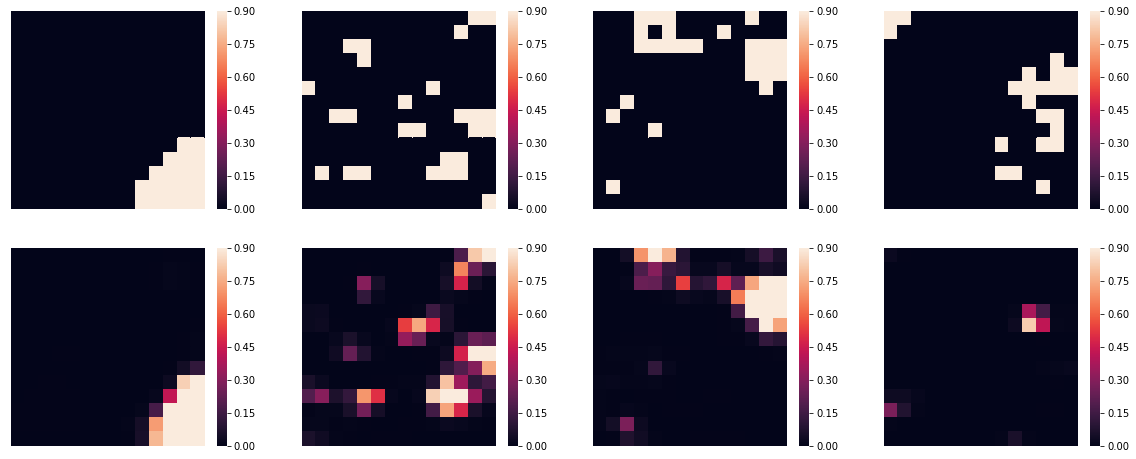

In [52]:
import random 

    
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = random.sample(test_ids, 4)z

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, STEPS, IMAGE_SIZE, IMAGE_SIZE, 17),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = test_y[idx].reshape(LABEL_SIZE, LABEL_SIZE)
    trues.append(true)
    

to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)
#plot_ids[ordering[976]//4] 

start = start + 4

0.4782608695652174
714
806
1192
1068


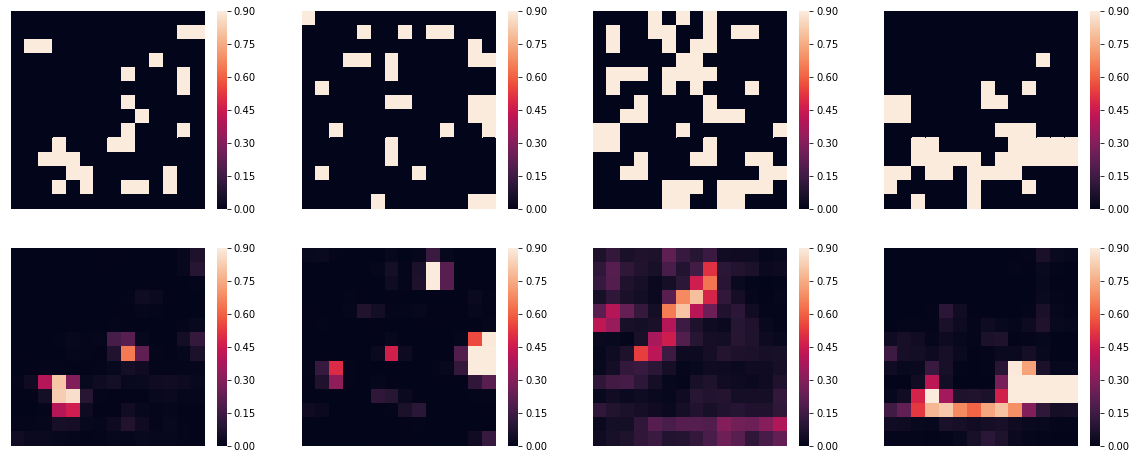

In [50]:
import random 

    
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
#matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
#              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
matrix_ids = random.sample(train_ids, 4)

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, STEPS, IMAGE_SIZE, IMAGE_SIZE, 17),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = train_y[idx].reshape(LABEL_SIZE, LABEL_SIZE)
    trues.append(true)
    

to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)
#plot_ids[ordering[976]//4] 
start = start + 4

In [ ]:
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x // 4 for x in outliers]))]
plot_ids2[ordering[460]//4] 

# Calculate ROC for best threshold selection

In [105]:
calculate_metrics()

Val loss: 0.26899999380111694 Thresh: 0.3 F1: 0.571 Recall: 0.552 Precision: 0.592 Error: 0.072


0.5714285714285715

## TODO @jombrandt top 10 worst training, test samples by IOU 

These should be written to a tmp/ .txt file and indexed by validate-data.ipynb to ensure that original classifications were correct, and to identify regions that need more training data.